In [1]:
from ast import arg
from architecture import *
import tiktoken
GPT_CONFIG_124M = Config()
tokenizer = tiktoken.get_encoding("gpt2")

txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch = [
    torch.tensor(tokenizer.encode(txt1)),
    torch.tensor(tokenizer.encode(txt2)),
]
batch = torch.stack(batch, dim=0)

torch.manual_seed(123)
# demo_config = Config(context_length=4)
model = GPTModel(config=GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)
probs = torch.softmax(logits, dim=-1)
print(probs)
argmax = torch.argmax(probs, dim=-1, keepdim=True)
print(argmax)

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1380,  0.0079, -0.1958,  ..., -0.0223, -0.1062,  0.1717],
         [ 0.3866, -0.8400, -0.6559,  ..., -0.5162,  0.2361, -0.3350],
         [ 0.6984, -0.1825, -0.1633,  ...,  0.1471, -0.6503, -0.0054],
         [-0.4288,  0.1671, -0.1261,  ...,  1.1572,  0.5297, -0.5542]],

        [[ 0.1094, -0.2890, -0.1463,  ..., -0.0558,  0.2907, -0.2818],
         [ 0.0883, -0.3544, -0.3523,  ...,  1.2921,  0.0050,  0.1902],
         [ 0.6092,  0.4702, -0.4092,  ...,  0.7682,  0.3781, -0.1969],
         [-0.0610, -0.0737,  0.4747,  ...,  1.2457, -0.3835,  0.0611]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[[1.9331e-05, 1.6973e-05, 1.3846e-05,  ..., 1.6469e-05,
          1.5143e-05, 1.9993e-05],
         [2.4808e-05, 7.2759e-06, 8.7461e-06,  ..., 1.0058e-05,
          2.1342e-05, 1.2056e-05],
         [3.3788e-05, 1.4002e-05, 1.4273e-05,  ..., 1.9469e-05,
          8.7706e-06, 1.6715e-05],
         [1.0932e-05, 1.9837e-05, 1.4796e-05,  ..., 5

In [2]:
GPT_CONFIG_124M_S = Config(
    vocab_size=50257,
    context_length=256,
    emb_dim=768,
    num_heads=12,
    num_layers=12,
    dropout=0.1,
    qkv_bias=False,
    bias=False,
)

torch.manual_seed(123)
model = GPTModel(config=GPT_CONFIG_124M_S)
model.eval()

GPTModel(
  (_tok_emd): Embedding(50257, 768)
  (_pos_emd): Embedding(256, 768)
  (_dropout): Dropout(p=0.1, inplace=False)
  (_transformers): Sequential(
    (0): TransformerBlock(
      (_norm_1): LayerNorm()
      (_attention): MultiHeadAttention(
        (_w_q): Linear(in_features=768, out_features=768, bias=False)
        (_w_k): Linear(in_features=768, out_features=768, bias=False)
        (_w_v): Linear(in_features=768, out_features=768, bias=False)
        (_out_proj): Linear(in_features=768, out_features=768, bias=True)
        (_dropout): Dropout(p=0.1, inplace=False)
      )
      (_drop_1): Dropout(p=0.1, inplace=False)
      (_norm_2): LayerNorm()
      (_ff): FeedForward(
        (_layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (_drop_2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock

In [3]:
def text_to_tokens(text: str, tokenizer) -> torch.Tensor:
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    return torch.tensor(encoded).unsqueeze(0)

def tokens_to_text(tokens: torch.Tensor, tokenizer) -> str:
    flatted_tokens = tokens.squeeze(0)
    return tokenizer.decode(flatted_tokens.tolist())

In [4]:
from architecture import generate_text_trivial
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_trivial(
    model=model,
    idx=text_to_tokens(start_context, tokenizer=tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M_S.context_length,)

print("Output text:")
print(tokens_to_text(token_ids, tokenizer=tokenizer))

Output text:
Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [5]:
def loss_cross_entropy(logits: torch.Tensor, target_tokens: torch.Tensor) -> torch.Tensor:
    flatten_logits = logits.flatten(0, 1) # flatten the batch and token dim, keep the logist of each token
    flatten_target_tokens = target_tokens.flatten(0)
    return torch.nn.functional.cross_entropy(flatten_logits, flatten_target_tokens)

In [28]:
from architecture import create_dataloader

file_path = "./data/openwebtext_subset.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text = f.read()
print(f"Length of text: {len(text)} characters")
tokens = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
print(f"Length of tokens: {len(tokens)} tokens")
train_ratio = 0.9
train_size = int(len(text) * train_ratio)
train_text = text[:train_size]
validate_text = text[train_size:]
print(f"Train size: {len(train_text)} characters")
print(f"Validate size: {len(validate_text)} characters")

train_loader = create_dataloader(
    text=train_text,
    batch_size=2,
    max_length=GPT_CONFIG_124M_S.context_length,
    stride=GPT_CONFIG_124M_S.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0,
    tokenizer=tokenizer)
validate_loader = create_dataloader(
    text=validate_text,
    batch_size=2,
    max_length=GPT_CONFIG_124M_S.context_length,
    stride=GPT_CONFIG_124M_S.context_length,
    drop_last=True,
    shuffle=False,
    num_workers=0,
    tokenizer=tokenizer)

print("Train data:")
for x, y in train_loader:
    print("x:", x.shape)
    print("y:", y.shape)
    print("x[0, :10]", x[0, :10])
    print("y[0, :10]", y[0, :10])

print("Validation data:")
for x, y in validate_loader:
    print("x:", x.shape)
    print("y:", y.shape)


Length of text: 4957120 characters
Length of tokens: 1127788 tokens
Train size: 4461408 characters
Validate size: 495712 characters
Train data:
x: torch.Size([2, 256])
y: torch.Size([2, 256])
x[0, :10] tensor([ 1245,   357, 33203,   874,   517,  3716,     8,   290, 12213,   351])
y[0, :10] tensor([  357, 33203,   874,   517,  3716,     8,   290, 12213,   351,  2071])
x: torch.Size([2, 256])
y: torch.Size([2, 256])
x[0, :10] tensor([  198,   198, 29067,  6712,   389,   287, 13975,  5876,    11,   329])
y[0, :10] tensor([  198, 29067,  6712,   389,   287, 13975,  5876,    11,   329,  3840])
x: torch.Size([2, 256])
y: torch.Size([2, 256])
x[0, :10] tensor([   25,  6656,    84, 33419,  2269,  1219,  1031,  1371, 25758,  2393])
y[0, :10] tensor([ 6656,    84, 33419,  2269,  1219,  1031,  1371, 25758,  2393,   198])
x: torch.Size([2, 256])
y: torch.Size([2, 256])
x[0, :10] tensor([ 683,  866,   11, 1201,  484,  836,  447,  247,   83, 9761])
y[0, :10] tensor([ 866,   11, 1201,  484,  836,  44

In [7]:
def calc_loss_batch(input_batch: torch.Tensor,
                    target_batch: torch.Tensor,
                    model: nn.Module,
                    device: torch.device,
                    ) -> torch.Tensor:
    input_batch = input_batch.to(device=device)
    target_batch = target_batch.to(device=device)
    logits = model(input_batch)
    return loss_cross_entropy(logits, target_batch)
    

In [8]:
def calc_loss_loader(data_loader: DataLoader,
                     model: nn.Module,
                     device: torch.device,
                     num_batches: int = 0):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches == 0:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input, target) in enumerate(data_loader):
        if i >= num_batches:
            break
        
        loss = calc_loss_batch(input_batch=input, target_batch=target, model=model, device=device)
        total_loss += loss
        
    return total_loss / num_batches

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(validate_loader, model, device)
    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

Training loss: tensor(10.9874, device='cuda:0')
Validation loss: tensor(10.9809, device='cuda:0')


In [13]:
def evaluate_model(
    model: nn.Module,
    train_loader: DataLoader,
    eval_loader: DataLoader,
    device: torch.device,
    eval_iter: int):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(data_loader=train_loader,
                                      model=model,
                                      device=device,
                                      num_batches=eval_iter)
        eval_loss = calc_loss_loader(data_loader=eval_loader,
                                      model=model,
                                      device=device,
                                      num_batches=eval_iter)
    model.train()
    return train_loss, eval_loss


def generate_sample(model: nn.Module,
                    context_size: int,
                    tokenizer,
                    device: torch.device,
                    start_context: str,
                    max_new_tokens: int=50) -> str:
    model.eval()
    encoded = text_to_tokens(text=start_context, tokenizer=tokenizer).to(device=device)
    with torch.no_grad():
        token_ids = generate_text_trivial(model=model,
                                          idx=encoded,
                                          max_new_tokens=max_new_tokens,
                                          context_size=context_size)
    model.train()
    return tokens_to_text(tokens=token_ids, tokenizer=tokenizer)

In [15]:
def train_model_simple(model: nn.Module,
                       train_loader: DataLoader,
                       eval_loader: DataLoader,
                       optimizer,
                       device: torch.device,
                       num_epochs: int,
                       eval_freq: int,
                       eval_iter: int, 
                       start_context: str,
                       tokenizer,
                       config: Config):
    train_losses, eval_losses, track_token_seen = [], [], []
    token_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input, target in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch=input, target_batch=target, model=model, device=device)
            loss.backward()
            optimizer.step()
            token_seen += input.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, eval_loss = evaluate_model(model=model,
                                                       train_loader=train_loader,
                                                       eval_loader=eval_loader,
                                                       device=device,
                                                       eval_iter=eval_iter)
                train_losses.append(train_loss)
                eval_losses.append(eval_loss)
                track_token_seen.append(token_seen)
                print(f"Epoch: {epoch} (step: {global_step:06d}): "
                    f"Train loss: {train_loss:.3f}, "
                    f"Eval loss: {eval_loss:.3f}"
                    )
        generated_text = generate_sample(model=model,
                        context_size=config.context_length,
                        tokenizer=tokenizer,
                        device=device,
                        start_context=start_context)
        print(f"""Generated text:
              -------------------------------
              {generated_text}
              -------------------------------""")
    return train_losses, eval_losses, track_token_seen

In [44]:
# torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
model.parameters(),
lr=0.0004, weight_decay=0.1
)
num_epochs = 5
train_losses, val_losses, tokens_seen = train_model_simple(
model, train_loader, validate_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=5, eval_iter=5,
start_context="Every effort moves you", tokenizer=tokenizer, config=GPT_CONFIG_124M
)

Epoch: 0 (step: 000000): Train loss: 10.104, Eval loss: 10.115
Epoch: 0 (step: 000005): Train loss: 8.978, Eval loss: 8.972
Epoch: 0 (step: 000010): Train loss: 7.897, Eval loss: 8.400
Epoch: 0 (step: 000015): Train loss: 8.186, Eval loss: 8.258
Epoch: 0 (step: 000020): Train loss: 8.378, Eval loss: 8.217
Epoch: 0 (step: 000025): Train loss: 8.121, Eval loss: 8.099
Epoch: 0 (step: 000030): Train loss: 7.861, Eval loss: 8.094
Epoch: 0 (step: 000035): Train loss: 7.817, Eval loss: 7.970
Epoch: 0 (step: 000040): Train loss: 7.715, Eval loss: 7.981
Epoch: 0 (step: 000045): Train loss: 7.719, Eval loss: 7.925
Epoch: 0 (step: 000050): Train loss: 7.511, Eval loss: 7.891
Epoch: 0 (step: 000055): Train loss: 7.531, Eval loss: 7.865
Epoch: 0 (step: 000060): Train loss: 7.833, Eval loss: 7.736
Epoch: 0 (step: 000065): Train loss: 7.457, Eval loss: 7.703
Epoch: 0 (step: 000070): Train loss: 7.432, Eval loss: 7.727
Epoch: 0 (step: 000075): Train loss: 7.336, Eval loss: 7.687
Epoch: 0 (step: 000080

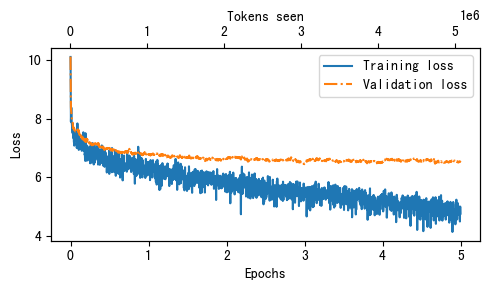

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
	fig, ax1 = plt.subplots(figsize=(5, 3))
	ax1.plot(epochs_seen.cpu(), train_losses, label="Training loss")
	ax1.plot(
		epochs_seen.cpu(), val_losses, linestyle="-.", label="Validation loss"
	)
	ax1.set_xlabel("Epochs")
	ax1.set_ylabel("Loss")
	ax1.legend(loc="upper right")
	ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
	ax2 = ax1.twiny()
	ax2.plot(tokens_seen, train_losses, alpha=0)
	ax2.set_xlabel("Tokens seen")
	fig.tight_layout()
	plt.show()
 
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses)).cpu()
# Ensure tokens_seen is on CPU and converted to numpy for plotting
if isinstance(tokens_seen, torch.Tensor):
	tokens_seen_plot = tokens_seen.detach().cpu().numpy()
elif isinstance(tokens_seen, list) and all(isinstance(t, torch.Tensor) for t in tokens_seen):
	tokens_seen_plot = [t.detach().cpu().item() if t.numel() == 1 else t.detach().cpu().numpy() for t in tokens_seen]
	# If it's a list of numpy arrays, flatten to a single numpy array if possible
	if all(isinstance(t, (int, float, np.integer, np.floating, np.ndarray)) for t in tokens_seen_plot):
		# If all elements are scalars or numpy arrays, flatten if possible
		if all(isinstance(t, (int, float, np.integer, np.floating)) for t in tokens_seen_plot):
			tokens_seen_plot = np.array(tokens_seen_plot)
		else:
			# If any element is a numpy array, concatenate them
			tokens_seen_plot = np.concatenate([t if isinstance(t, np.ndarray) else np.array([t]) for t in tokens_seen_plot])
else:
	tokens_seen_plot = tokens_seen
# Ensure train_losses and val_losses are numpy arrays on CPU for plotting
if isinstance(train_losses, torch.Tensor):
	train_losses_plot = train_losses.detach().cpu().numpy()
else:
	train_losses_plot = np.array([i.cpu() for i in train_losses])
if isinstance(val_losses, torch.Tensor):
	val_losses_plot = val_losses.detach().cpu().numpy()
else:
	val_losses_plot = np.array([i.cpu() for i in val_losses])

plot_losses(epochs_tensor, tokens_seen_plot, train_losses_plot, val_losses_plot)